In [1]:
%%capture
!pip install wandb -qqq
import wandb

In [2]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import math
import random

wandb.init(project='test-drive', config={
    'learning_rate': 0.02,
    'dropout': 0.2,
    'architecture': 'CNN',
    'dataset': 'CIFAR-100',
})
config = wandb.config

for x in range(50):
    acc = math.log(1 + x+ random.random() * config.learning_rate) + random.random()
    loss = 10 - math.log(1 + x + random.random() + config.learning_rate * x) + random.random()
    wandb.log({'acc':acc, 'loss':loss})

wandb.finish()

wandb: Currently logged in as: kade (use `wandb login --relogin` to force relogin)


acc,4.22868
loss,6.48216
_runtime,4
_timestamp,1628218494
_step,49


acc,▁▁▂▃▃▄▄▄▄▄▅▅▆▅▆▆▇▅▆▆▆▇▇▆▆▆▇▇▇▆▆▆▇▇▇▇▆▇█▇
loss,█▇▆▅▅▅▄▄▅▅▃▄▄▄▄▄▃▄▄▃▃▄▂▃▂▂▂▂▂▂▂▃▂▂▂▁▁▂▂▂
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


# Simple Keras DNN

In [10]:
# Simple Keras Model

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback

experiment_name = wandb.util.generate_id()

wandb.init(
    project='intro-demo',
    group=experiment_name,
    config={
        'layer_1': 512,
        'activation_1': 'relu',
        'dropout': 0.2,
        'layer_2': 10,
        'activation_2': 'softmax',
        'optimizer': 'sgd',
        'loss': 'sparse_categorical_crossentropy',
        'metric': 'accuracy',
        'epoch': 6,
        'batch_size': 32
    }
)
config = wandb.config

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255., x_test/255.
x_train, y_train = x_train[::5], y_train[::5] # subset data for a faster demo

# Build a model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(config.layer_1, activation=config.activation_1),
    tf.keras.layers.Dropout(config.dropout),
    tf.keras.layers.Dense(config.layer_2, activation=config.activation_2)
])

model.compile(optimizer=config.optimizer,
              loss=config.loss,
              metrics=[config.metric])

history = model.fit(x_train, y_train,
                    epochs=config.epoch,
                    batch_size=config.batch_size,
                    validation_data=(x_test, y_test),
                    # WandbCallback 사용 -> 자동으로 대쉬보드에 히스토리 저장
                    callbacks=[WandbCallback()])

wandb.finish()

Epoch 1/6
375/375 [==============================] - 2s 6ms/step - loss: 1.2204 - accuracy: 0.7045 - val_loss: 0.6848 - val_accuracy: 0.8446
Epoch 2/6
375/375 [==============================] - 2s 6ms/step - loss: 0.5947 - accuracy: 0.8511 - val_loss: 0.4809 - val_accuracy: 0.8821
Epoch 3/6
375/375 [==============================] - 2s 6ms/step - loss: 0.4687 - accuracy: 0.8736 - val_loss: 0.4059 - val_accuracy: 0.8958
Epoch 4/6
375/375 [==============================] - 2s 5ms/step - loss: 0.4045 - accuracy: 0.8910 - val_loss: 0.3708 - val_accuracy: 0.9013
Epoch 5/6
375/375 [==============================] - 2s 6ms/step - loss: 0.3736 - accuracy: 0.8973 - val_loss: 0.3440 - val_accuracy: 0.9087
Epoch 6/6
375/375 [==============================] - 2s 6ms/step - loss: 0.3443 - accuracy: 0.9053 - val_loss: 0.3258 - val_accuracy: 0.9118


epoch,5
loss,0.34432
accuracy,0.90533
val_loss,0.32582
val_accuracy,0.9118
_runtime,17
_timestamp,1628219214
_step,5
best_val_loss,0.32582
best_epoch,5


epoch,▁▂▄▅▇█
loss,█▃▂▁▁▁
accuracy,▁▆▇███
val_loss,█▄▃▂▁▁
val_accuracy,▁▅▆▇██
_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█


# Log Analysis

In [11]:
%%capture
!pip install scikit-plot -qqq

f1,0.9118
_runtime,20
_timestamp,1628219640
_step,0


f1,▁
_runtime,▁
_timestamp,▁
_step,▁


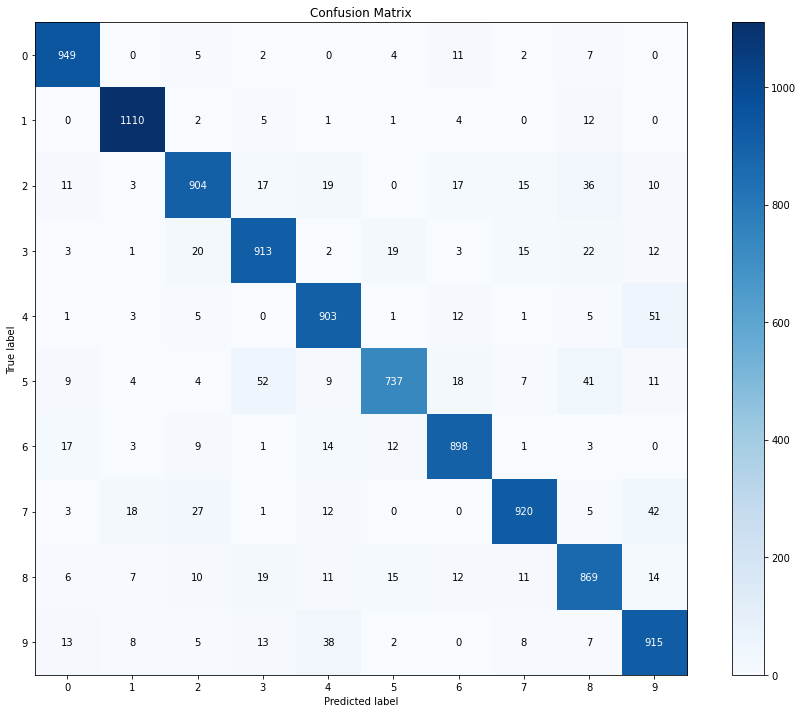

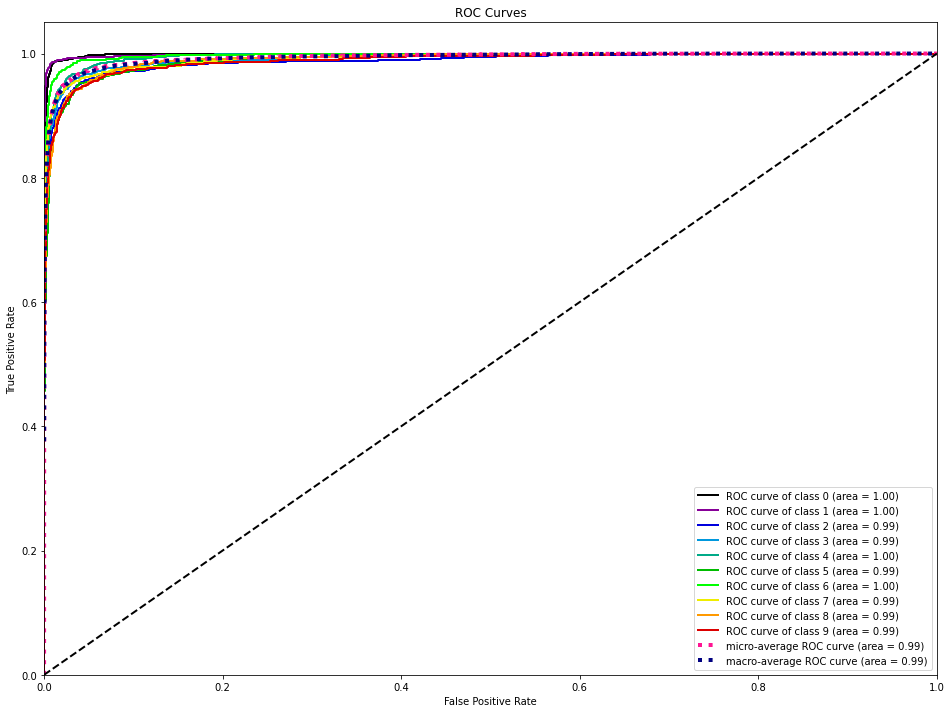

In [13]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix, plot_roc

wandb.init(project='intro-demo', group=experiment_name)

# Log F1 Score
y_test_pred = np.asarray(model.predict(x_test))
y_test_pred_class = np.argmax(y_test_pred, axis=1)
f1 = f1_score(y_test, y_test_pred_class, average='micro')
wandb.log({'f1':f1},
          commit=False)

# Log Confusion Matrix
fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(y_test, y_test_pred_class, ax=ax)
wandb.log({'confusion_matrix': wandb.Image(fig)}, commit=False)

# Log ROC Curve
fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(y_test, y_test_pred, ax=ax)
wandb.log({'plot_roc': wandb.Image(fig)}, commit=True) # 모든걸 로깅

class_score_data = []
for test, pred in zip(y_test, y_test_pred):
    class_score_data.append([test, pred])

wandb.log({'class_scores': wandb.Table(data=class_score_data,
                                       columns=['test', 'pred'])})

In [ ]:
print(y_test)